In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import RocCurveDisplay, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from tools_ml.data_process import filter_features
from tools_ml.models import get_pipeline

In [4]:
df_raw = pd.read_csv("data/application_train.csv")

# Dropando a coluna de gênero e SK_ID_CURR
df_raw.drop("CODE_GENDER", inplace=True, axis=1)
df_raw.drop("SK_ID_CURR", inplace=True, axis=1)

# Filtrando as features com mais de 50% de valores nulos
df_raw_fil = filter_features(df_raw, 0.5)

In [5]:
# Features Numéricas
features_num = df_raw_fil.select_dtypes(include=np.number).columns.tolist()
features_num.remove('TARGET')

# Features Categóricas
features_cat = df_raw_fil.select_dtypes(exclude=np.number).columns.tolist()

# Selecionando features que possuem menos de 10 categorias
df_num = df_raw_fil[features_num]
novas_cat = df_num.nunique()[df_num.nunique()<10].sort_values()
novas_cat.drop([
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK'
], inplace=True)

features_cat = features_cat + novas_cat.index.tolist()
features_num = df_raw_fil.columns.drop(features_cat).tolist()
features_num.remove('TARGET')

In [6]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df_raw_fil.drop(columns='TARGET'),
    df_raw_fil['TARGET'],
    train_size=0.7,
    random_state=42,
    stratify=df_raw_fil['TARGET']
)

In [7]:
pipe_final = get_pipeline(
    features_cat=features_cat,
    features_num=features_num,
    classifier=BalancedRandomForestClassifier(random_state=42, n_estimators=100)
)

In [20]:
# Hyperparam tuning
espaco_hiper = {
    'classifier__n_estimators': [200, 300, 400],
    'classifier__max_depth': [20, 30, 40]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_brfc = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-2,
    verbose=5,
    random_state=42
)

rand_brfc.fit(X_train, y_train);

c:\Users\Guilerme\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [15]:
# Getting predictions
y_pred = rand_brfc.predict(X_test)

c:\Users\Guilerme\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
# Model report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     67812
           1       0.16      0.65      0.25      5991

    accuracy                           0.69     73803
   macro avg       0.56      0.67      0.53     73803
weighted avg       0.89      0.69      0.76     73803



In [17]:
df_report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(df_report).transpose()
df_report

,precision,recall,f1-score,support
0,0.957518,0.690350,0.802276,67812.000000
1,0.157113,0.653313,0.253309,5991.000000
accuracy,0.687343,0.687343,0.687343,0.687343
macro avg,0.557315,0.671832,0.527792,73803.000000
weighted avg,0.892544,0.687343,0.757713,73803.000000


In [18]:
# Params and Score
print("Best Parameters:")
for param, value in rand_brfc.best_params_.items():
    print(f"  - {param.title()}: {value:.2g}")
print(f"Best Score: {rand_brfc.best_score_:.2g}") 

Best Parameters:


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

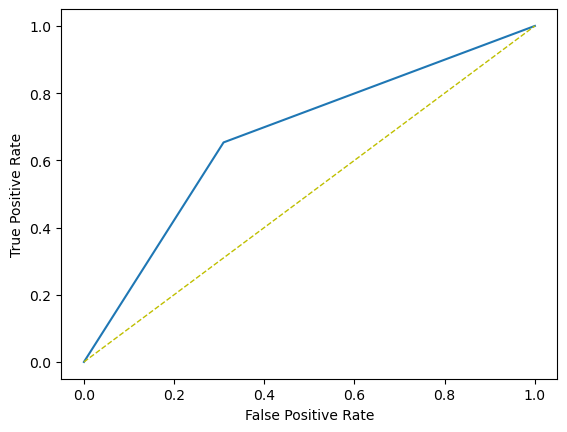

In [19]:
# Roc Curve
fpr, tpr, thr = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()
plt.plot([0,1], [0,1], '--', color = 'y', linewidth= 1)
plt.show()